#Objective:
A machine learning project that detects the presence of diseases in plants using image data. The model analyzes leaf images to classify whether a plant is healthy or affected by a specific disease, helping support early detection and agricultural health monitoring.

#Column Details:
* **temperature:** Measured in degrees Celsius
* **humidity**: Measured as percentage
* **rainfall**: Measured in millimeters
* **soil_pH**: Acidity/alkalinity measurement
* **disease_present**: Binary label (0 = healthy, 1 = diseased)


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Loading the dataset
data = pd.read_csv("/content/plant_disease_dataset.csv")
data.head()

,temperature,humidity,rainfall,soil_pH,disease_present
0,27.483571,33.215053,0.572758,4.975875,1
1,24.308678,36.945005,42.522346,8.165266,0
2,28.238443,34.026189,16.095303,6.316734,1
3,32.615149,41.104180,20.311015,6.164949,0
4,23.829233,51.971785,11.851323,8.482468,0


In [3]:
data.tail()

,temperature,humidity,rainfall,soil_pH,disease_present
9995,31.505510,81.939137,22.406822,5.862952,1
9996,15.008275,86.886833,10.503881,4.070539,0
9997,21.473416,81.891770,13.426869,7.101583,0
9998,27.478828,88.567649,9.719659,7.732620,0
9999,28.221942,71.900401,4.886391,4.383536,0


In [4]:
data.shape

(10000, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      10000 non-null  float64
 1   humidity         10000 non-null  float64
 2   rainfall         10000 non-null  float64
 3   soil_pH          10000 non-null  float64
 4   disease_present  10000 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,10000.0,25.612191,5.813841,5.387999,21.815610,25.293238,28.916048,56.686495
humidity,10000.0,62.119300,22.679977,6.244209,40.772925,72.211752,81.032999,102.395421
rainfall,10000.0,9.807522,9.852130,0.000055,2.812822,6.864898,13.442871,84.654161
soil_pH,10000.0,6.245855,1.302465,4.000075,5.122970,6.232188,7.386377,8.499875
disease_present,10000.0,0.241000,0.427712,0.000000,0.000000,0.000000,0.000000,1.000000


In [7]:
data.isnull().sum()

,0
temperature,0
humidity,0
rainfall,0
soil_pH,0
disease_present,0


In [8]:
print(data.duplicated().sum())

0


In [9]:
data['disease_present'].map({1:"Yes", 0:"No"}).value_counts()

,count
disease_present,
No,7590
Yes,2410


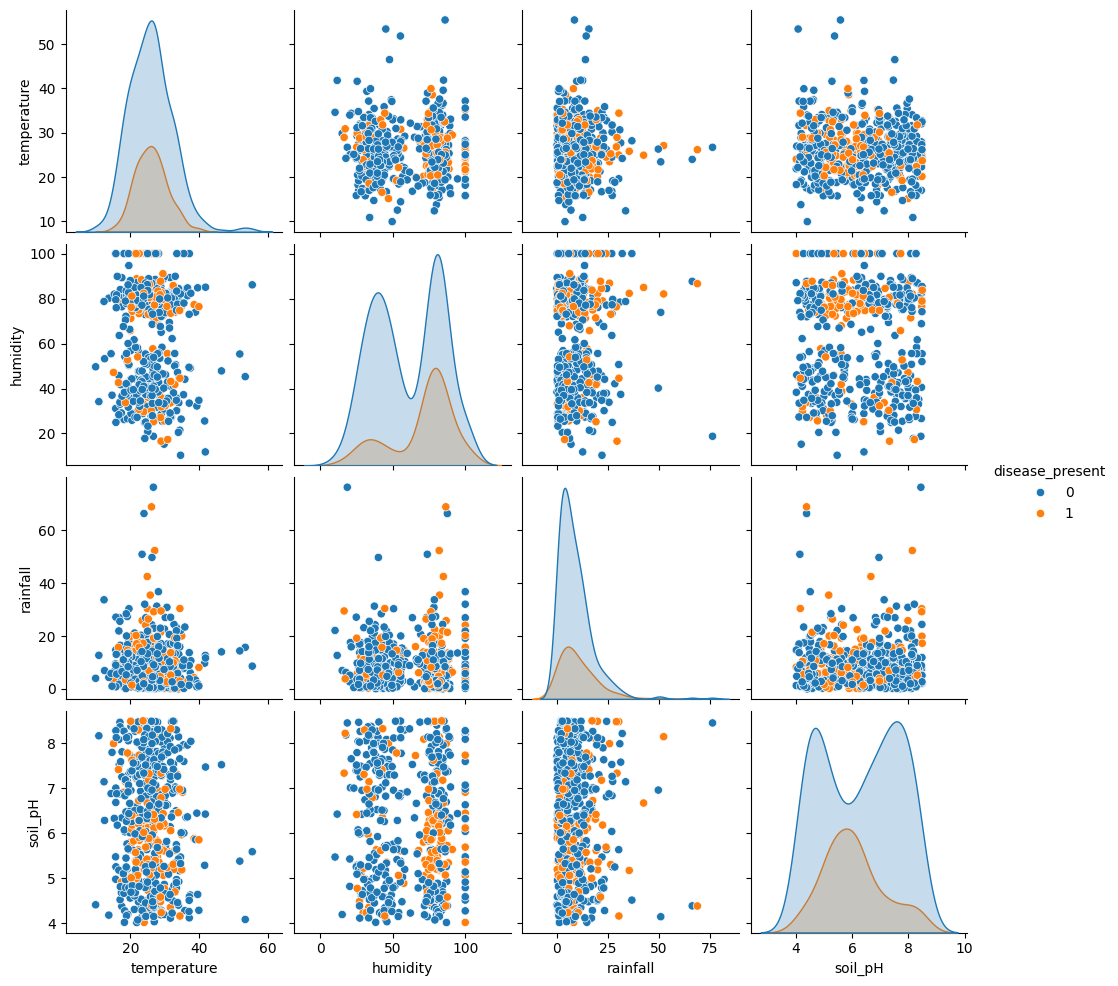

In [10]:
# Pirplot
sns.pairplot(data.sample(500), hue='disease_present')
plt.show()

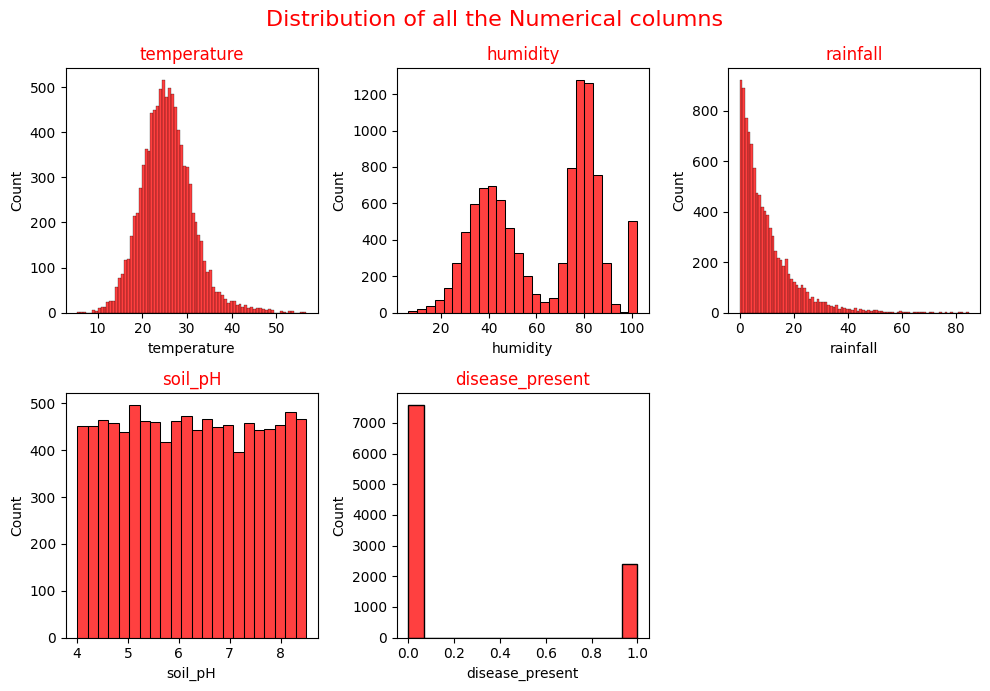

In [11]:
# Let's check the distribution of all the numerical columns
plt.figure(figsize=(10, 7))
plt.suptitle("Distribution of all the Numerical columns", size=16, color="red")
index = 0
for col in data.columns:
    index += 1
    plt.subplot(2, 3, index)
    plt.title(f"{col}", color="red")
    sns.histplot(data[col], color="red")
    plt.tight_layout()
plt.show()

* Looks like most of the columns are normally distributed except for "rainfall".

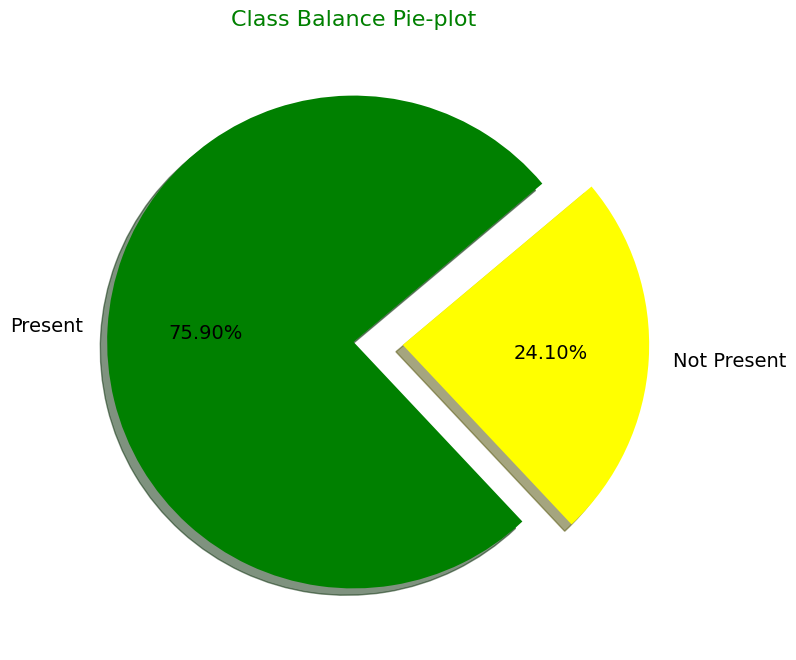

In [12]:
# Checking for class imbalance
plt.figure(figsize=(8, 8))
plt.pie(data['disease_present'].value_counts(), autopct="%.2f%%", colors=['green', 'yellow'],
        labels=['Present', 'Not Present'], explode=[0, 0.2], shadow=True, textprops={"fontsize":14},
        startangle=40)
plt.title("Class Balance Pie-plot", color='green', size=16)
plt.show()

* With this pie plot we can infer that there is a presence of class imbalance in the dataset, still we will work on it only if our classifier models are not able to classify the minority class correctly.

In [13]:
# Let's separate features and target variable
x = data.drop('disease_present', axis=1)
y = data['disease_present']
x.shape, y.shape

((10000, 4), (10000,))

In [14]:
# Let's separate the data for training and testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8000, 4), (2000, 4), (8000,), (2000,))

In [15]:
# Let's scale our dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

In [16]:
# Let's create a method to evaluate our models
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score
)

# Global dictionary to store results
model_results = {}

def eval_metrics(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)

    # --- Print classification report ---
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    # --- Confusion matrix ---
    print("\n🔢 Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

    # --- Compute metrics ---
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)

    # --- Build a unique model key ---
    base_name = model.__class__.__name__
    i = 1
    key = base_name
    while key in model_results:
        i += 1
        key = f"{base_name}_{i}"

    # --- Store metrics in the dictionary ---
    model_results[key] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec
    }

    print(f"\n✅ Stored results under key: '{key}'")

In [17]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

lr = LogisticRegression()#fit_intercept=False, C=10)
lr.fit(x_train_s, y_train)

LogisticRegression()


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1518
           1       0.67      0.13      0.21       482

    accuracy                           0.77      2000
   macro avg       0.72      0.55      0.54      2000
weighted avg       0.75      0.77      0.71      2000


🔢 Confusion Matrix:

✅ Stored results under key: 'LogisticRegression_2'


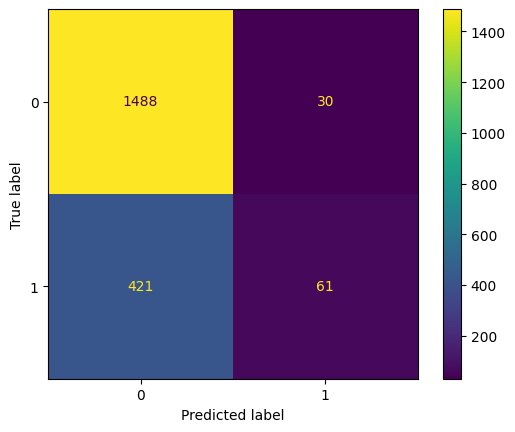

In [26]:
from sklearn.metrics import accuracy_score, classification_report

# print(classification_report(y_test, lr.predict(x_test_s)))
eval_metrics(lr, x_test_s, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1518
           1       0.67      0.13      0.21       482

    accuracy                           0.77      2000
   macro avg       0.72      0.55      0.54      2000
weighted avg       0.75      0.77      0.71      2000


🔢 Confusion Matrix:

✅ Stored results under key: 'LogisticRegressionCV'


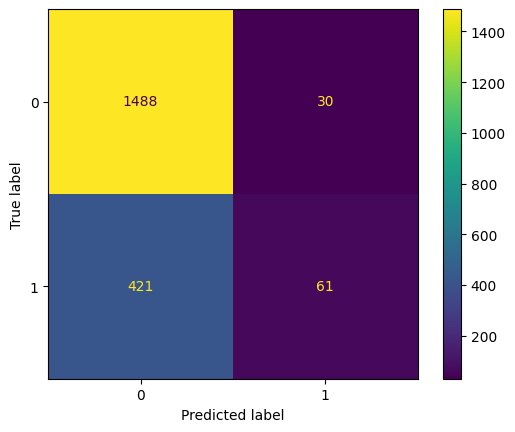

In [27]:
lrcv = LogisticRegressionCV(cv=4)
lrcv.fit(x_train_s, y_train)

# print(classification_report(y_test, lrcv.predict(x_test_s)))
eval_metrics(lrcv, x_test_s, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1518
           1       0.53      0.58      0.56       482

    accuracy                           0.78      2000
   macro avg       0.70      0.71      0.70      2000
weighted avg       0.78      0.78      0.78      2000


🔢 Confusion Matrix:

✅ Stored results under key: 'DecisionTreeClassifier'


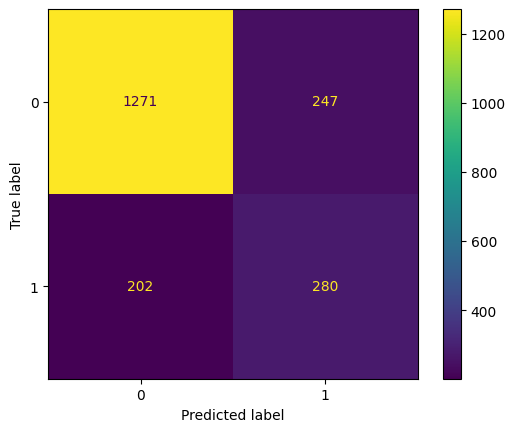

In [28]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
# print(classification_report(y_test, dtc.predict(x_test)))
eval_metrics(dtc, x_test, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1518
           1       0.78      0.60      0.68       482

    accuracy                           0.86      2000
   macro avg       0.83      0.77      0.80      2000
weighted avg       0.86      0.86      0.86      2000


🔢 Confusion Matrix:

✅ Stored results under key: 'RandomForestClassifier'


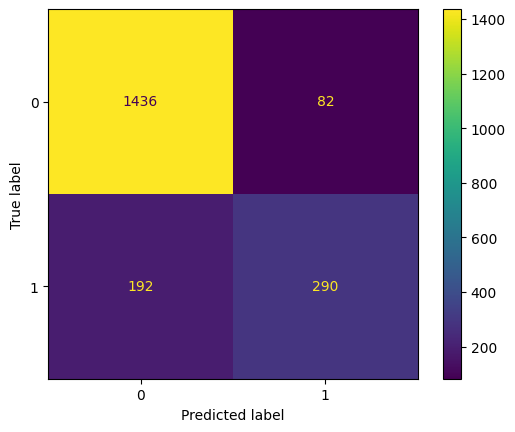

In [29]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
# print(classification_report(y_test, rfc.predict(x_test)))
eval_metrics(rfc, x_test, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1518
           1       0.72      0.46      0.56       482

    accuracy                           0.83      2000
   macro avg       0.78      0.70      0.73      2000
weighted avg       0.81      0.83      0.81      2000


🔢 Confusion Matrix:

✅ Stored results under key: 'SVC_2'


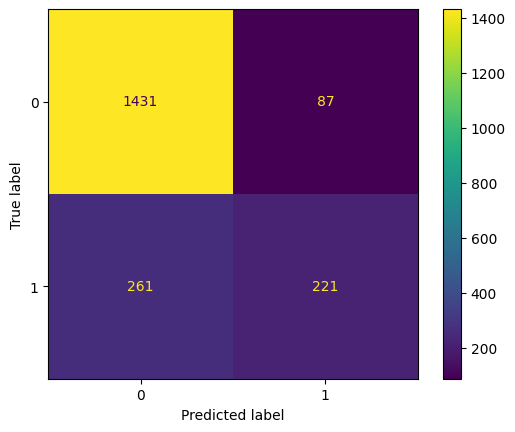

In [31]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf')
svc.fit(x_train_s, y_train)
# print(classification_report(y_test, svc.predict(x_test_s)))
eval_metrics(svc, x_test_s, y_test)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=20)
knc.fit(x_train_s, y_train)
# print(classification_report(y_test, knc.predict(x_test_s)))


              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1518
           1       0.77      0.54      0.63       482

    accuracy                           0.85      2000
   macro avg       0.82      0.74      0.77      2000
weighted avg       0.84      0.85      0.84      2000



In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score
)